In [1]:
import csv
import networkx as nx
import numpy as np
from random import randint
import random
import csv
import networkx as nx
import numpy as np
from random import randint
from sklearn.linear_model import LogisticRegression
from xgboost import plot_importance


EDGE_LIST_PATH = '../input/citation-prediction-altegrad/edgelist.txt'

In [2]:
from sklearn.metrics import plot_confusion_matrix, log_loss, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import smart_open
import gensim

def read_corpus(fname, tokens_only=False):
    with smart_open.open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            tokens = gensim.utils.simple_preprocess(line)
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

def other_metrics(graph, edges):
    similarity_dice = graph.similarity_dice(pairs = edges)
    similarity_jaccard = graph.similarity_jaccard(pairs = edges)
    return similarity_dice, similarity_jaccard

def evaluate_estimator(clf, X_test, y_test):
    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()
    y_pred = clf.predict_proba(X_test)[:, 1]
    print("accuracy",accuracy_score(y_test, (y_pred>0.5)))
    print("log_loss", log_loss(y_test, y_pred, eps=1e-7))
    print("auc", roc_auc_score(y_test, y_pred))
    plt.hist(y_pred)
    plt.show()
    

**Load graph**

In [3]:
# Create a graph
G = nx.read_edgelist(EDGE_LIST_PATH, delimiter=',', create_using=nx.Graph(), nodetype=int)
nodes = list(G.nodes())
n = G.number_of_nodes()
m = G.number_of_edges()
print('Number of nodes:', n)
print('Number of edges:', m)

Number of nodes: 138499
Number of edges: 1091955


**negative edges**: random sampling of pair of nodes

In [4]:
def generate_negative_edges(G, m):
    #f = open("/content/drive/negative_edgelist.txt", "w")
    f = open("./negative_edgelist.txt", "w")
    my_set = set()
    edges = set(G.edges())
    for i in range(m):
        n1 = nodes[randint(0, n-1)]
        n2 = nodes[randint(0, n-1)]
        while ((n1,n2) in my_set or (n2,n1) in my_set) or ((n1,n2) in edges or (n2,n1) in edges):
            n2 = nodes[randint(0, n-1)]
        my_set.add((n1,n2))
        f.write(str(n1) +',' +str(n2)+'\n')
    f.close() 
    verif = sum(1 for line in open('negative_edgelist.txt'))
    if m != len(my_set) or m != verif:
        print("Attention, mauvais nombre de negative edges")
        print(m, len(my_set), verif)
    f.close()
    del my_set

#generate_negative_edges(G, m=2*G.number_of_edges())

In [5]:
#neg_G = nx.read_edgelist('../input/second-order-metrics-train-test/negative_edgelist.txt', delimiter=',', nodetype=int)
#neg_G = nx.read_edgelist('./negative_edgelist.txt', delimiter=',', nodetype=int)
#print('Number of nodes:', neg_G.number_of_nodes())
#print('Number of edges:', neg_G.number_of_edges())

**train-test split** :
* training_graph : train edges positive
* neg_G: train edges negative

* test_edge_list : test edges positive
* test_neg_edge_list: test edges negative


In [6]:
import random
boolSAGE = True

if boolSAGE:
    #with open('../input/marine-sub/train_test_split.npy', 'rb') as f:
    with open('../input/sage-v2/train_test_split.npy', 'rb') as f:
        
        train_pos_u = np.load(f)
        train_pos_v = np.load(f)
        train_neg_u = np.load(f)
        train_neg_v = np.load(f)

        test_pos_u = np.load(f)
        test_pos_v = np.load(f)
        test_neg_u = np.load(f)
        test_neg_v = np.load(f)
        
    test_edge_list_split = [(test_pos_u[i], test_pos_v[i]) for i in range(len(test_pos_u))]
    test_neg_edge_list = [(test_neg_u[i], test_neg_v[i]) for i in range(len(test_neg_u))]
    #neg_G = nx.read_edgelist('../input/marine-sub/negative_edgelist.txt', delimiter=',', nodetype=int)
    neg_G = nx.read_edgelist('../input/sage-v2/negative_edgelist.txt', delimiter=',', nodetype=int)
    print('Number of nodes:', neg_G.number_of_nodes())
    print('Number of edges:', neg_G.number_of_edges())
    del train_pos_u, train_pos_v, train_neg_u, train_neg_v, test_pos_u, test_pos_v, test_neg_u, test_neg_v
else:
    test_edge_list_split = random.sample(G.edges(), int(0.5 * G.number_of_edges()))
    test_edge_list = list(test_edge_list_split)
    test_neg_edge_list = random.sample(neg_G.edges(), int(0.5 * neg_G.number_of_edges()))

# Remove some edges
training_graph = G.copy()
training_graph.remove_edges_from(test_edge_list_split)
neg_G.remove_edges_from(test_neg_edge_list)


Number of nodes: 138499
Number of edges: 3275865


In [7]:
 print("verification",training_graph.number_of_edges(), neg_G.number_of_edges())


verification 788853 2366964


In [8]:
y_test = np.zeros(len(test_edge_list_split) + len(test_neg_edge_list))
y_test[:len(test_edge_list_split)] = 1
test_nodes = test_edge_list_split + test_neg_edge_list
del test_edge_list_split, test_neg_edge_list

**first iteration:** sum of degrees and diff of degrees.

In [9]:
import gc


def give_features_baseline(graph, edges, abstracts = None):
    
    sum_degree = [G.degree(n1) + G.degree(n2) for (n1,n2) in edges]
    diff_degree = [abs(G.degree(n1) - G.degree(n2)) for (n1,n2) in edges]
    
    if abstracts is not None:
        len1 = np.array([len(abstracts[edge[0]]) for edge in edges])
        len2 = np.array([len(abstracts[edge[1]]) for edge in edges])
        ab1 = len1 + len2
        ab2 = np.abs(len1 - len2)
        del len1, len2
        ab3 = [len(abstracts[edge[0]].intersection(abstracts[edge[1]])) for edge in edges]
        return np.c_[sum_degree, diff_degree, ab1, ab2, ab3]
    
    return np.c_[sum_degree, diff_degree]


def give_features_from_list_pairs(graph, edges):
    '''
    graph must be from igraph
    graph  = igraph.Graph.from_networkx(training_graph)
    '''
    similarity_dice = graph.similarity_dice(pairs = edges)
    similarity_jaccard = graph.similarity_jaccard(pairs = edges)
    return np.c_[similarity_dice,similarity_jaccard]


def give_features_from_embedding(emb, edges):
    '''
    edges can be an iterator
    '''
    dist = emb[[i for i in map(lambda x: x[0], edges)]] - emb[[i for i in map(lambda x: x[1], edges)]]
    l2_dist_neg = np.linalg.norm(dist, ord = 2, axis = 1)
    l1_dist_neg = np.linalg.norm(dist, ord = 1, axis = 1)
    del dist
    
    hadamard_neg = np.sum(emb[[i for i in map(lambda x: x[0],  edges)]] * emb[[i for i in map(lambda x: x[1],  edges)]], axis = 1)
    
    return np.c_[l2_dist_neg, l1_dist_neg, hadamard_neg]


def give_authors_features(authors_list_per_node, edges):
    
    common_authors = [len(np.intersect1d(authors_list_per_node[n1], authors_list_per_node[n2] ,assume_unique=True)) for (n1,n2) in edges]
    #weighted len en fonction de la popularité des auteurs ?
    return np.c_[common_authors]




**USE embeddings**

In [10]:
with open('../input/altegrad-use/USE_embedding.npy', 'rb') as f:
    vecs = np.load(f)
    print(vecs.shape)

X_train_pos_USE = give_features_from_embedding(vecs, training_graph.edges())
X_train_neg_USE = give_features_from_embedding(vecs, neg_G.edges())
X_test_USE = give_features_from_embedding(vecs, test_nodes)

del vecs

gc.collect()

(138499, 512)


29

**docVec embeddings**

In [11]:
docVec = gensim.models.doc2vec.Doc2Vec.load('../input/altegrad-gensim-draft/docVec.model')
vecs = docVec.dv.get_normed_vectors()
del docVec

X_train_pos_docVec = give_features_from_embedding(vecs, training_graph.edges())
X_train_neg_docVec = give_features_from_embedding(vecs, neg_G.edges())
X_test_docVec = give_features_from_embedding(vecs, test_nodes)

del vecs

gc.collect()

45

**baseline**

In [12]:
# Read the abstract of each paper
abstracts = dict()
with open("../input/citation-prediction-altegrad/abstracts.txt", 'r') as f:
    for line in f:
        node, abstract = line.split('|--|')
        abstracts[int(node)] = abstract

# Map text to set of terms
for node in abstracts:
    abstracts[node] = set(abstracts[node].split())
    
X_train_pos_baseline = give_features_baseline(training_graph, training_graph.edges(), abstracts = abstracts)
X_train_neg_baseline = give_features_baseline(training_graph, neg_G.edges(), abstracts = abstracts)
X_test_baseline = give_features_baseline(training_graph, test_nodes, abstracts = abstracts)

del abstracts

gc.collect()


0

In [13]:
import re
import unidecode
regex = re.compile('[^a-zA-Z ,]')

def process_author(s):
    l = s.split()
    l = [m[:3].upper() for m in l]
    return ' '.join(l)

def process_authors_split(s):
    s = s.replace('Janne Heikkil #x E', 'Janne Heikkila')
    s = s.replace('Samuel Rota Bul #x F', "Samuel Rota Bulo")
    s = s.replace('Maria Salam #x F,Llorente', 'Maria Salamo Llorente')
    s = s.replace('Patrick H #x E,as,dric Herzet', 'Patrick Heas, Cedric Herzet')
    s = s.replace('Etienne M #x E,min', 'Etienne Memin')
    s = regex.sub('', s)
    
    authors_split = s.split(',')
    authors_split = [process_author(a) for a in authors_split]
    
    return authors_split

authors_list_per_node = []
authors_list = []
nodes = []
nodes_per_authors = {}

with open('../input/citation-prediction-altegrad/authors.txt', 'r', errors = 'strict') as f:
    for line in f:
        #do stuff
        node, authors = line.split('|--|')
        
        #process errors
        authors = unidecode.unidecode(authors)

        #', -'
        authors_split = process_authors_split(authors)
    
        authors_list_per_node.append(authors_split)
        authors_list += authors_split
        nodes.append(node)
        
        for a in authors_split:
            l = nodes_per_authors.get(a, [])
            nodes_per_authors[a] = l + [node]
        

del nodes_per_authors, authors_list


X_train_pos_authors = give_authors_features(authors_list_per_node,  training_graph.edges())
X_train_neg_authors = give_authors_features(authors_list_per_node,  neg_G.edges())
X_test_authors = give_authors_features(authors_list_per_node,  test_nodes)

del authors_list_per_node

gc.collect()

0

**SAGE**

In [14]:
#with open('../input/marine-sub/embeddingSAGE.npy', 'rb') as f:
with open('../input/sage-v2/embeddingSAGE.npy', 'rb') as f:

    vecs = np.load(f)
    print(vecs.shape)

X_train_pos_SAGE = give_features_from_embedding(vecs, training_graph.edges())
X_train_neg_SAGE = give_features_from_embedding(vecs, neg_G.edges())
X_test_SAGE = give_features_from_embedding(vecs, test_nodes)

del vecs

gc.collect()

(138499, 16)


29

**Validation with metrics**

In [15]:
nb_x = training_graph.number_of_edges() + neg_G.number_of_edges()
y_train = np.zeros(training_graph.number_of_edges() + neg_G.number_of_edges())
y_train[:training_graph.number_of_edges()] = 1

idx_shuffle = np.arange(nb_x)
np.random.shuffle(idx_shuffle)
y_train = y_train[idx_shuffle]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:46:58] WARNING: ../src/learner.cc:576: 
Parameters: { "gpu_predictor" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:46:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


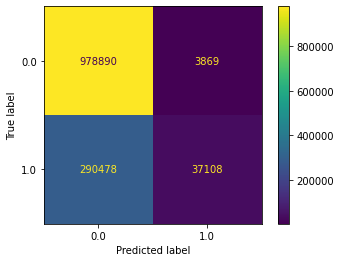

accuracy 0.7753667927148957
log_loss 0.5295445195849469
auc 0.5547618418975406


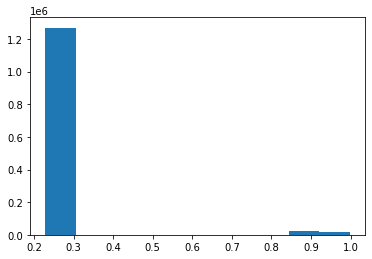

In [16]:
X_train = np.concatenate([X_train_pos_authors, X_train_neg_authors])
X_test = X_test_authors

clf = xgb.XGBClassifier(n_estimators = 800, max_depth = 4, subsample = 0.7, colsample_bytree = 0.75,  tree_method = 'gpu_hist',gpu_predictor = 'gpu_predictor')
clf.fit(X_train[idx_shuffle,:], y_train)


evaluate_estimator(clf, X_test, y_test)

(3155817, 6) (1310345, 6)


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:16] WARNING: ../src/learner.cc:576: 
Parameters: { "gpu_predictor" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


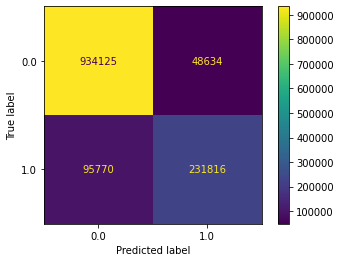

accuracy 0.8897969618688208
log_loss 0.2723804457054607
auc 0.9306970296116173


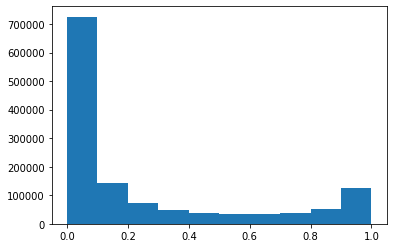

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

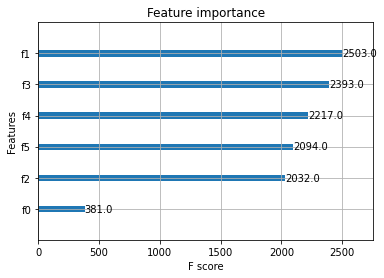

In [17]:
X_train = np.c_[X_train,np.concatenate([X_train_pos_baseline, X_train_neg_baseline])]
X_test = np.c_[X_test, X_test_baseline]
print(X_train.shape, X_test.shape)

clf = xgb.XGBClassifier(n_estimators = 800, max_depth = 4, subsample = 0.7, colsample_bytree = 0.75,  tree_method = 'gpu_hist',gpu_predictor = 'gpu_predictor')
clf.fit(X_train[idx_shuffle,:], y_train)


evaluate_estimator(clf, X_test, y_test)
plt.show()
plot_importance(clf, )

(3155817, 9) (1310345, 9)


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:45] WARNING: ../src/learner.cc:576: 
Parameters: { "gpu_predictor" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


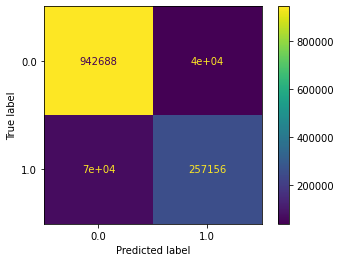

accuracy 0.9156703005696973
log_loss 0.21513594749784568
auc 0.9573919324034335


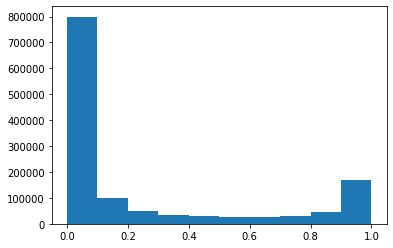

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

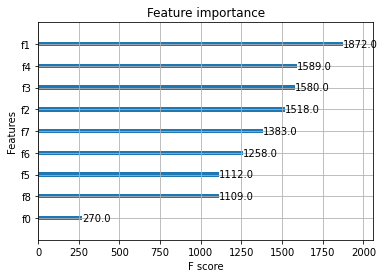

In [18]:
X_train = np.c_[X_train,np.concatenate([X_train_pos_USE, X_train_neg_USE])]
X_test = np.c_[X_test, X_test_USE]
print(X_train.shape, X_test.shape)

clf = xgb.XGBClassifier(n_estimators = 800, max_depth = 4, subsample = 0.7, colsample_bytree = 0.75,  tree_method = 'gpu_hist',gpu_predictor = 'gpu_predictor')
clf.fit(X_train[idx_shuffle,:], y_train)


evaluate_estimator(clf, X_test, y_test)
plt.show()
plot_importance(clf, )

(3155817, 12) (1310345, 12)


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:48:15] WARNING: ../src/learner.cc:576: 
Parameters: { "gpu_predictor" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:48:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


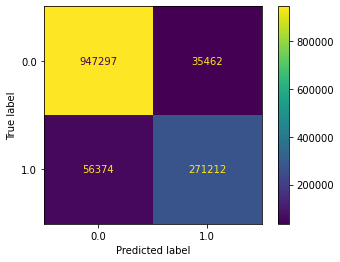

accuracy 0.9299146408007052
log_loss 0.1808716474771832
auc 0.970308035621972


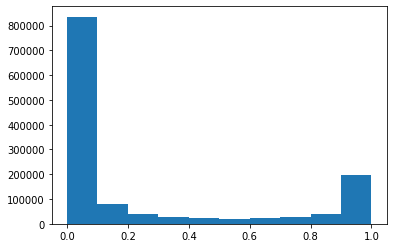

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

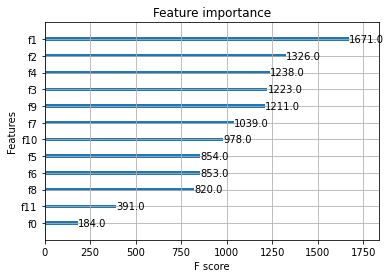

In [19]:
X_train = np.c_[X_train,np.concatenate([X_train_pos_docVec, X_train_neg_docVec])]
X_test = np.c_[X_test, X_test_docVec]
print(X_train.shape, X_test.shape)

clf = xgb.XGBClassifier(n_estimators = 800, max_depth = 4, subsample = 0.7, colsample_bytree = 0.75,  tree_method = 'gpu_hist',gpu_predictor = 'gpu_predictor')
clf.fit(X_train[idx_shuffle,:], y_train)


evaluate_estimator(clf, X_test, y_test)
plt.show()
plot_importance(clf, )

(3155817, 15) (1310345, 15)


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:48:47] WARNING: ../src/learner.cc:576: 
Parameters: { "gpu_predictor" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:48:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


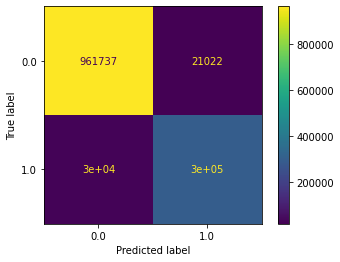

accuracy 0.9608751893585277
log_loss 0.11157309079271756
auc 0.9886992154126466


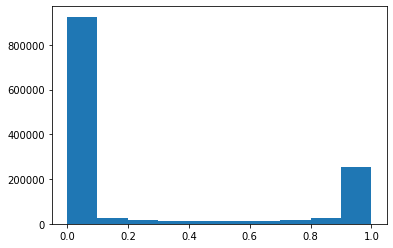

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

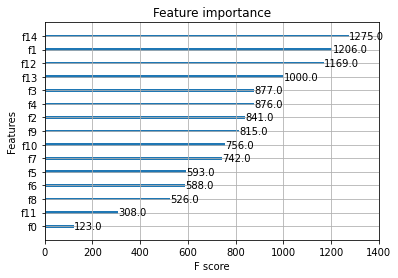

In [20]:
X_train = np.c_[X_train,np.concatenate([X_train_pos_SAGE, X_train_neg_SAGE])]
X_test = np.c_[X_test, X_test_SAGE]
print(X_train.shape, X_test.shape)

clf = xgb.XGBClassifier(n_estimators = 800, max_depth = 4, subsample = 0.7, colsample_bytree = 0.75,  tree_method = 'gpu_hist',gpu_predictor = 'gpu_predictor')
clf.fit(X_train[idx_shuffle,:], y_train)


evaluate_estimator(clf, X_test, y_test)
plt.show()
plot_importance(clf, )

# submit

In [21]:
# Read test data. Each sample is a pair of nodes
node_pairs = list()
with open('../input/citation-prediction-altegrad/test.txt', 'r') as f:
    for line in f:
        t = line.split(',')
        node_pairs.append((int(t[0]), int(t[1])))

In [22]:
with open('../input/altegrad-use/USE_embedding.npy', 'rb') as f:
    vecs = np.load(f)
    print(vecs.shape)

X_valid_USE = give_features_from_embedding(vecs, node_pairs)

del vecs

gc.collect()

(138499, 512)


41759

In [23]:
docVec = gensim.models.doc2vec.Doc2Vec.load('../input/altegrad-gensim-draft/docVec.model')
vecs = docVec.dv.get_normed_vectors()
del docVec

X_valid_docVec = give_features_from_embedding(vecs, node_pairs)

del vecs

gc.collect()

45

In [24]:
#with open('../input/marine-sub/embeddingSAGE.npy', 'rb') as f:
with open('../input/sage-v2/embeddingSAGE.npy', 'rb') as f:
    vecs = np.load(f)
    print(vecs.shape)


X_valid_SAGE = give_features_from_embedding(vecs, node_pairs)

del vecs

gc.collect()

(138499, 16)


29

In [25]:
import re
import unidecode
regex = re.compile('[^a-zA-Z ,]')

def process_author(s):
    l = s.split()
    l = [m[:3].upper() for m in l]
    return ' '.join(l)

def process_authors_split(s):
    s = s.replace('Janne Heikkil #x E', 'Janne Heikkila')
    s = s.replace('Samuel Rota Bul #x F', "Samuel Rota Bulo")
    s = s.replace('Maria Salam #x F,Llorente', 'Maria Salamo Llorente')
    s = s.replace('Patrick H #x E,as,dric Herzet', 'Patrick Heas, Cedric Herzet')
    s = s.replace('Etienne M #x E,min', 'Etienne Memin')
    s = regex.sub('', s)
    
    authors_split = s.split(',')
    authors_split = [process_author(a) for a in authors_split]
    
    return authors_split

authors_list_per_node = []
authors_list = []
nodes = []
nodes_per_authors = {}

with open('../input/citation-prediction-altegrad/authors.txt', 'r', errors = 'strict') as f:
    for line in f:
        #do stuff
        node, authors = line.split('|--|')
        
        #process errors
        authors = unidecode.unidecode(authors)

        #', -'
        authors_split = process_authors_split(authors)
    
        authors_list_per_node.append(authors_split)
        authors_list += authors_split
        nodes.append(node)
        
        for a in authors_split:
            l = nodes_per_authors.get(a, [])
            nodes_per_authors[a] = l + [node]
        

del nodes_per_authors, authors_list

X_valid_authors = give_authors_features(authors_list_per_node,  node_pairs)

del authors_list_per_node

gc.collect()

0

In [26]:
# Read the abstract of each paper
abstracts = dict()
with open("../input/citation-prediction-altegrad/abstracts.txt", 'r') as f:
    for line in f:
        node, abstract = line.split('|--|')
        abstracts[int(node)] = abstract

# Map text to set of terms
for node in abstracts:
    abstracts[node] = set(abstracts[node].split())
    
X_valid_baseline = give_features_baseline(training_graph, node_pairs, abstracts = abstracts)

del abstracts

gc.collect()


0

In [27]:
X_valid = np.c_[X_valid_authors, X_valid_baseline, X_valid_USE, X_valid_docVec, X_valid_SAGE]
print(X_valid.shape)

(106692, 15)


In [28]:
y_pred = clf.predict_proba(X_valid)
print(y_pred.shape, y_pred[:5], clf.predict(X_valid)[:5])
y_pred = y_pred[:,1]

# Write predictions to a file
predictions = zip(range(len(y_pred)), y_pred)
with open("submission.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for row in predictions:
        csv_out.writerow(row) 

(106692, 2) [[8.3836114e-01 1.6163889e-01]
 [9.7682279e-01 2.3177180e-02]
 [1.2993240e-01 8.7006760e-01]
 [4.9438119e-02 9.5056188e-01]
 [9.9969429e-01 3.0570285e-04]] [0. 0. 1. 1. 0.]
